In [19]:
import pandas as pd
import random
from gensim.models import Word2Vec
from scipy.spatial.distance import cosine
from scipy.stats import ttest_ind
import seaborn as sns
import matplotlib.pyplot as plt



In [2]:
df_train = pd.read_csv("RB198.csv")


In [3]:
# Function to alter a certain percentage of residues in a sequence
def alter_sequence(sequence, alter_percent):
    sequence = list(sequence)
    num_to_alter = int(len(sequence) * alter_percent / 100)
    positions = random.sample(range(len(sequence)), num_to_alter)
    for pos in positions:
        sequence[pos] = random.choice('ACDEFGHIKLMNPQRSTVWY')  # 20 standard amino acids
    return ''.join(sequence)

def cosine_similarity(vec1, vec2):
    return 1 - cosine(vec1, vec2)

In [52]:
original_sequences = df_train['Sequence'].tolist()

# Generate datasets with altered sequences
alter_percentages = [40, 45, 50, 55]
altered_datasets = {percent: [] for percent in alter_percentages}

for seq in original_sequences:
    for percent in alter_percentages:
        altered_seq = alter_sequence(seq, percent)
        altered_datasets[percent].append(altered_seq)


In [54]:
# Train Word2Vec models on each altered dataset
word2vec_models = {}
epochs = [ 100 , 200 , 300 , 400]
for (percent, sequences) , epoch in zip(altered_datasets.items() , epochs):
    # Tokenize sequences for Word2Vec (simple tokenization by splitting each residue as a token)
    tokenized_sequences = [[residue for residue in seq] for seq in sequences]
    model = Word2Vec(sentences=tokenized_sequences, vector_size=25, window=5, min_count=1, workers=1 , epochs=epoch, sg=0, negative=5)
    word2vec_models[percent] = model


In [55]:
import numpy as np

amino_acids = word2vec_models[40].wv.index_to_key
semantic_relationships = {percent: {} for percent in alter_percentages}

for percent, model in word2vec_models.items():
    for aa1 in amino_acids:
        for aa2 in amino_acids:
            if aa1 != aa2:
                vec1 = model.wv[aa1]
                vec2 = model.wv[aa2]
                similarity = cosine_similarity(vec1, vec2)
                if aa1 not in semantic_relationships[percent]:
                    semantic_relationships[percent][aa1] = []
                semantic_relationships[percent][aa1].append(similarity)

p_value_matrix = pd.DataFrame(index=amino_acids, columns=amino_acids)

# Perform pairwise t-tests and fill the p-value matrix
for aa1 in amino_acids:
    for aa2 in amino_acids:
        if aa1 != aa2:
            similarities_aa1 = [semantic_relationships[percent][aa1] for percent in alter_percentages]
            similarities_aa2 = [semantic_relationships[percent][aa2] for percent in alter_percentages]
            t_stat, p_val = ttest_ind(similarities_aa1, similarities_aa2)
            p_value_matrix.at[aa1, aa2] = np.average(p_val)
        else:
            p_value_matrix.at[aa1, aa2] = 1  # Self-comparison is not needed



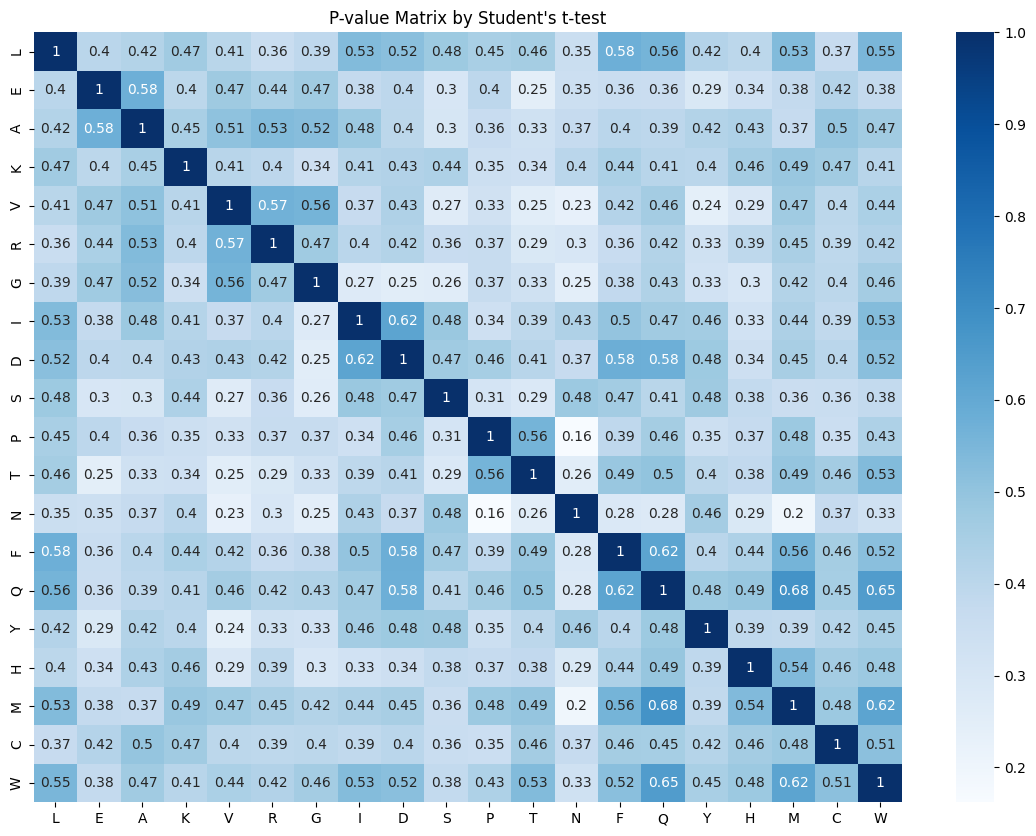

In [56]:
# Convert the p-value matrix to float
p_value_matrix = p_value_matrix.astype(float)

# Plot the heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(p_value_matrix, annot=True, cmap="Blues", cbar=True)
plt.title("P-value Matrix by Student's t-test")
plt.show()

# New way of doing

In [71]:
# Function to train Word2Vec models
def train_word2vec(sequences, vector_size=100, window=5, min_count=1, sg=1 , workers = 5 , epochs = 100 , negative = 0):
    sequences_split = [list(seq) for seq in sequences]
    model = Word2Vec(sequences_split, vector_size=vector_size, window=window, min_count=min_count, sg=sg , workers = workers , epochs = epochs , negative = negative)
    return model

# Compute cosine similarities
def compute_cosine_similarities(model, amino_acids):
    similarities = {}
    for aa1 in amino_acids:
        similarities[aa1] = {}
        for aa2 in amino_acids:
            similarities[aa1][aa2] = 1 - cosine(model.wv[aa1], model.wv[aa2])
    return similarities

# Function to generate altered datasets
def generate_altered_datasets(original_sequences, alteration_rates=[0.4, 0.45, 0.5, 0.55]):
    altered_datasets = []
    for rate in alteration_rates:
        altered_sequences = [alter_sequence(seq, rate) for seq in original_sequences]
        altered_datasets.append(altered_sequences)
    return altered_datasets

# Function to randomly alter sequences
def alter_sequence(sequence, alteration_rate=0.5):
    sequence = list(sequence)
    num_to_alter = int(len(sequence) * alteration_rate)
    indices_to_alter = np.random.choice(len(sequence), num_to_alter, replace=False)
    for idx in indices_to_alter:
        sequence[idx] = np.random.choice(list('ACDEFGHIKLMNPQRSTVWY'))  # Random amino acid
    return ''.join(sequence)

In [73]:
original_sequences = df_train['Sequence'].to_list()
altered_datasets = generate_altered_datasets(original_sequences)
epochs = [100 , 200 , 300 , 400]
shuffled_models = [train_word2vec(dataset, vector_size=25, window=5, min_count=1, workers=1 , epochs=epoch, sg=0, negative=5) for dataset , epoch in zip(altered_datasets, epochs)]
original_model = train_word2vec(original_sequences , vector_size=25, window=5, min_count=1, workers=1 , epochs=200, sg=0, negative=5)


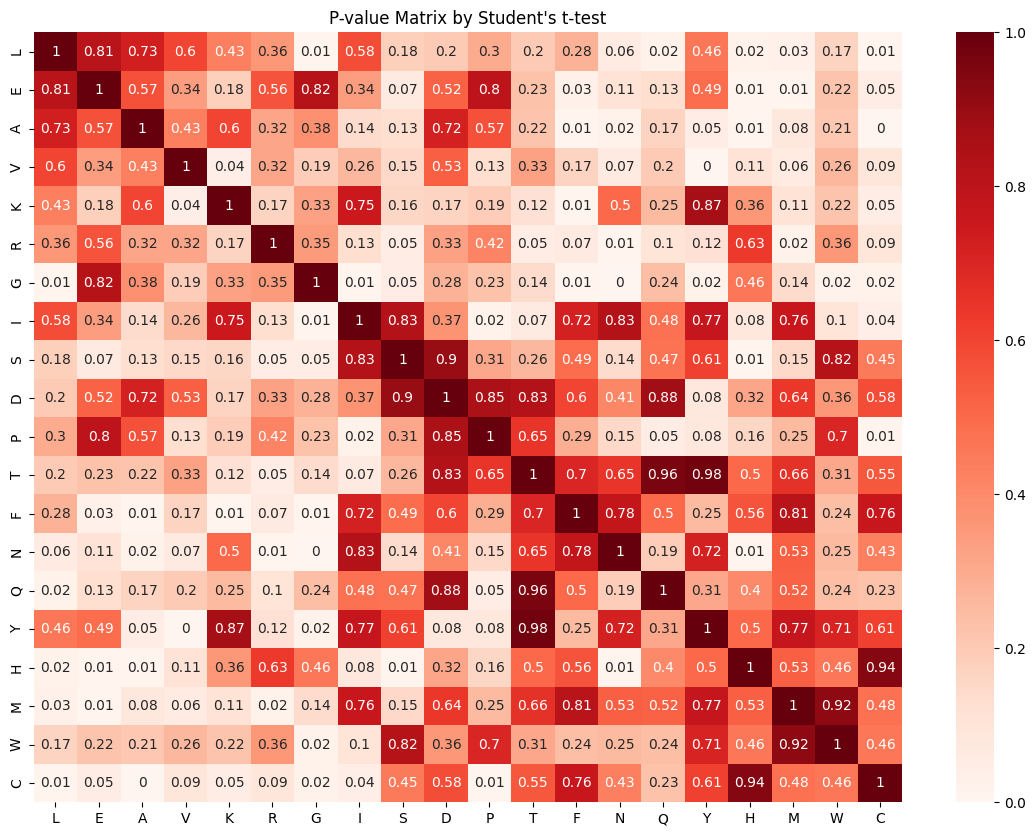

In [74]:
amino_acids = original_model.wv.index_to_key

original_similarities = compute_cosine_similarities(original_model, amino_acids)
altered_similarities = [compute_cosine_similarities(model, amino_acids) for model in shuffled_models]

# Perform t-tests
p_value_matrix = pd.DataFrame(index=amino_acids, columns=amino_acids, data=0.0)

for aa1 in amino_acids:
    for aa2 in amino_acids:
        if aa1 == aa2 :
          p_value_matrix.at[aa1, aa2] = 1
        else :
          similarities = [alt_sim[aa1][aa2] for alt_sim in altered_similarities]
          # Perform a t-test comparing the similarities from the original dataset and the altered datasets
          t_stat, p_val = ttest_ind([original_similarities[aa1][aa2]], similarities)
          p_value_matrix.at[aa1, aa2] = p_val


p_value_matrix = p_value_matrix.astype(float).round(2)
plt.figure(figsize=(14, 10))
sns.heatmap(p_value_matrix, annot=True, cmap="Reds")
plt.title("P-value Matrix by Student's t-test")
plt.show()